Import packages

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os

os.chdir(r"c:/Users/JosephVovrosh/personalgit")

Train the model:

In [19]:
# ----- CONFIG -----
WINDOW_SIZE = 31*2
PREDICT_SIZE = 15
BATCH_SIZE = 200
EPOCHS = 50
LEARNING_RATE = 1e-3

# ----- LOAD DATA -----
df = pd.read_csv("Kaggle-Store_Sales/training_data.csv", parse_dates=["date"])
df.sort_values(by=["store_nbr", "family", "date"], inplace=True)

cutoff = pd.Timestamp("2013-10-01")
df_train = df[df['date'] <= cutoff]

df_train = df_train.copy()
df_train['day_sin'] = np.sin(2 * np.pi * df_train['date'].dt.weekday / 7)
df_train['day_cos'] = np.cos(2 * np.pi * df_train['date'].dt.weekday / 7)

# # ----- FEATURE ENGINEERING -----
features = ["day_sin", "day_cos", "sales", "onpromotion"]#, "cluster", "type", "city", "state", "transactions", "dcoilwtico", "type_local", "transferred_local", "type_regional", "transferred_regional", "type_national", "transferred_national"]

# # Normalize sales per group
# df['sales'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten())

# scaler = MinMaxScaler()
# df_train[features] = scaler.fit_transform(df_train[features])


In [20]:
# ----- CREATE SEQUENCES -----
class SalesDataset(Dataset):
    def __init__(self, df, window_size, predict_size):
        self.X = []
        self.y = []
        
        for _, group in df.groupby(['store_nbr', 'family']):
            group = group.sort_values('date')
            values = group[features].values
            sales = group['sales'].values
            
            for i in range(len(group) - window_size - predict_size):
                input_seq = values[i:i+window_size]
                target_seq = sales[i+window_size:i+window_size+predict_size]
                
                self.X.append(input_seq)
                self.y.append(target_seq)

        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SalesDataset(df_train, WINDOW_SIZE, PREDICT_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
# ----- MODEL -----
class FeedforwardNet(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=PREDICT_SIZE):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size * WINDOW_SIZE, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x)

model = FeedforwardNet(input_size=len(features))

# ----- RMSLE LOSS -----
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        y_pred = torch.clamp(y_pred, min=0)
        y_true = torch.clamp(y_true, min=0)
        return torch.sqrt(self.mse(torch.log1p(y_pred), torch.log1p(y_true)))

criterion = RMSLELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Epoch 1/50: 100%|██████████| 1756/1756 [00:13<00:00, 126.85it/s]


Epoch 1: Train Loss = 1.0138, Test Loss = 0.9141


Epoch 2/50: 100%|██████████| 1756/1756 [00:16<00:00, 105.50it/s]


Epoch 2: Train Loss = 0.9390, Test Loss = 0.9146


Epoch 3/50: 100%|██████████| 1756/1756 [00:16<00:00, 107.77it/s]


Epoch 3: Train Loss = 0.7678, Test Loss = 0.3312


Epoch 4/50: 100%|██████████| 1756/1756 [00:14<00:00, 118.48it/s]


Epoch 4: Train Loss = 0.3379, Test Loss = 0.3290


Epoch 5/50: 100%|██████████| 1756/1756 [00:14<00:00, 124.56it/s]


Epoch 5: Train Loss = 0.3356, Test Loss = 0.3306


Epoch 6/50: 100%|██████████| 1756/1756 [00:14<00:00, 125.23it/s]


Epoch 6: Train Loss = 0.3335, Test Loss = 0.3272


Epoch 7/50: 100%|██████████| 1756/1756 [00:14<00:00, 119.55it/s]


Epoch 7: Train Loss = 0.3323, Test Loss = 0.3280


Epoch 8/50: 100%|██████████| 1756/1756 [00:17<00:00, 101.28it/s]


Epoch 8: Train Loss = 0.3311, Test Loss = 0.3277


Epoch 9/50: 100%|██████████| 1756/1756 [00:15<00:00, 110.13it/s]


Epoch 9: Train Loss = 0.3308, Test Loss = 0.3308


Epoch 10/50: 100%|██████████| 1756/1756 [00:14<00:00, 121.05it/s]


Epoch 10: Train Loss = 0.3309, Test Loss = 0.3362


Epoch 11/50: 100%|██████████| 1756/1756 [00:14<00:00, 118.99it/s]


Epoch 11: Train Loss = 0.3291, Test Loss = 0.3281


Epoch 12/50: 100%|██████████| 1756/1756 [00:21<00:00, 79.96it/s] 


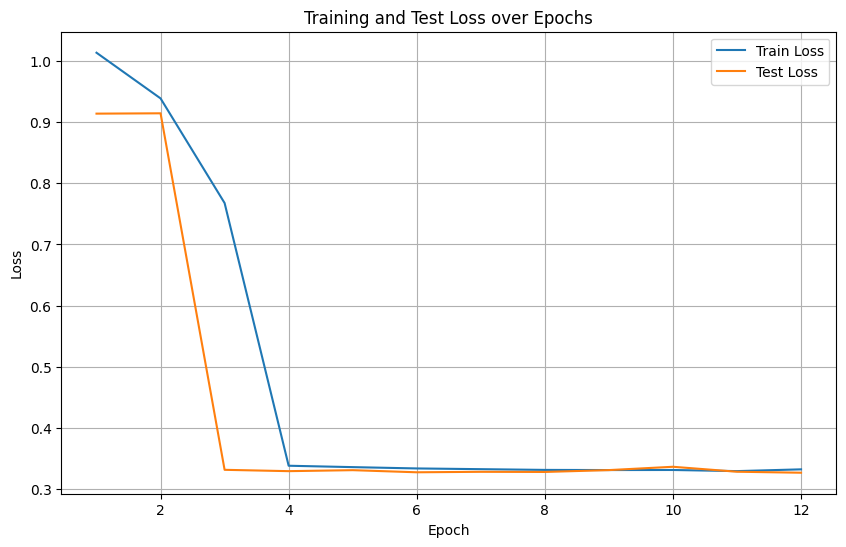

Final Train Loss = 0.3320, Final Test Loss = 0.3265


In [22]:
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(dataloader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test set
    model.eval()
    all_preds = []
    all_trues = []

    y_test_df = df[(cutoff < df['date']) & (df['date'] <= cutoff + pd.Timedelta(days=PREDICT_SIZE))]
    y_test_grouped = y_test_df.groupby(['store_nbr', 'family'])

    with torch.no_grad():
        for (store, family), group in df_train.groupby(['store_nbr', 'family']):
            group = group.sort_values('date')
            input_seq = group[features].values[-WINDOW_SIZE:]
            if len(input_seq) < WINDOW_SIZE:
                continue
            
            input_seq_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)  # add batch dim
            
            pred = model(input_seq_tensor).squeeze(0).cpu().numpy()
            
            try:
                true_group = y_test_grouped.get_group((store, family)).sort_values('date')
                true_sales = true_group['sales'].values[:PREDICT_SIZE]
                if len(true_sales) < PREDICT_SIZE:
                    continue
            except KeyError:
                continue
            
            all_preds.append(pred)
            all_trues.append(true_sales)

    if all_preds and all_trues:
        all_preds_tensor = torch.tensor(np.vstack(all_preds), dtype=torch.float32)
        all_trues_tensor = torch.tensor(np.vstack(all_trues), dtype=torch.float32)
        test_loss = criterion(all_preds_tensor, all_trues_tensor).item()
    else:
        test_loss = float('nan')  # in case no valid predictions
    test_losses.append(test_loss)

    if len(train_losses) >= 5:
        if train_losses[epoch-4] < train_losses[epoch]:
            EPOCHS = epoch+1
            break

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {test_loss:.4f}")

# Save model after training
torch.save(model.state_dict(), "sales_forecast_model.pth")

# Plot losses
plt.figure(figsize=(10,6))
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


print(f"Final Train Loss = {avg_train_loss:.4f}, Final Test Loss = {test_loss:.4f}")